<a href="https://colab.research.google.com/github/chandan9t8/Diabetic-Retinopathy-Classifier/blob/main/DRClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I attempt to build a Diabetic Retinopathy Classifier using `MobileNetV2`.

Diabetic Retinopathy affects individuals with long standing diabetes resulting in visual problems and eventually vision loss. The existing methods for detecting Diabetic Retinopathy often rely on subjective assessments and extensive manual labor, leading to inefficiencies and potential inconsistencies in diagnosis. Therefore, there is a need to develop a robust and reliable automated system that can accurately detect it.

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d pkdarabi/diagnosis-of-diabetic-retinopathy
!unzip diagnosis-of-diabetic-retinopathy.zip

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, ZeroPadding2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling

`image_data_set_from_directory()` -- directly loads data from the disk into train and test sets. `seed` in train and val sets are set to the same number for reproducible results.

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_path = "./diagnosis_of_diabetic_retinopathy/train"
val_path = "./diagnosis_of_diabetic_retinopathy/valid"
test_path = "./diagnosis_of_diabetic_retinopathy/test"
train_dataset = image_dataset_from_directory(train_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             seed=42)
validation_dataset = image_dataset_from_directory(val_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             seed=42)
test_dataset = image_dataset_from_directory(test_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                            )

Found 2076 files belonging to 2 classes.
Found 531 files belonging to 2 classes.
Found 231 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names
print(class_names)

['DR', 'No_DR']


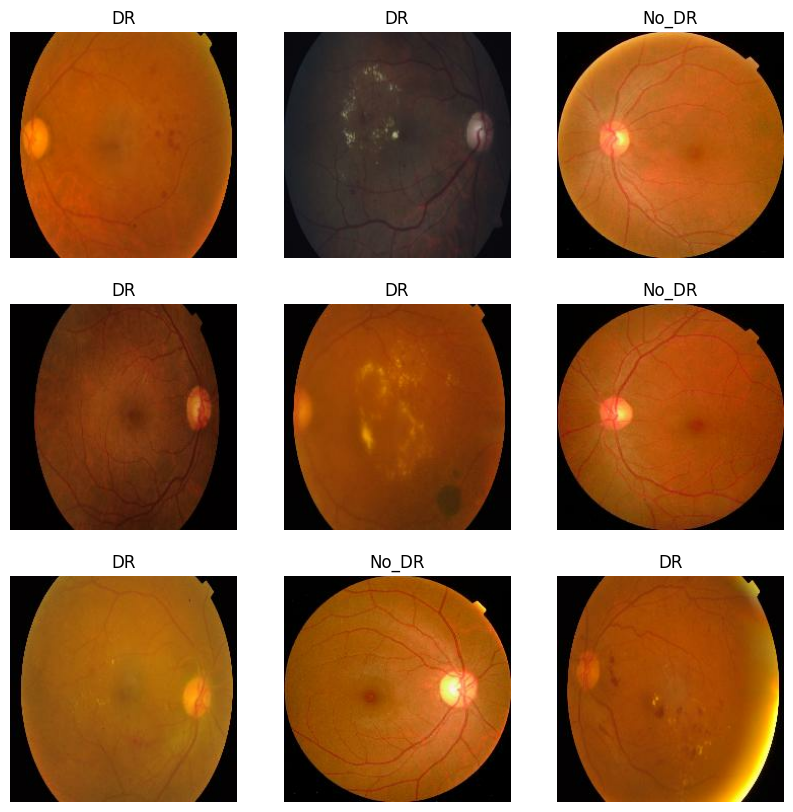

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):    #takes 1 batch from the training set
    for i in range(9):                          #iterate over 1st 9 images in the batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])                  #set the title to the corresponding class name
        plt.axis("off")

`prefetch()` -- prevents memory bottleneck  when reading from disk. It sets aside some data and keeps it ready when needed. No of elements to prefetch can be set manually or ask `tf` to do it(using `tf.data.experimental.AUTOTUNE`).

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

Since our dataset is small, we can increase its size using simple data augmentation techniques such as rotation, mirroring etc. Data Augmentation also adds diversity to the dataset.

In [ ]:
def data_aug():

  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))

  return data_augmentation

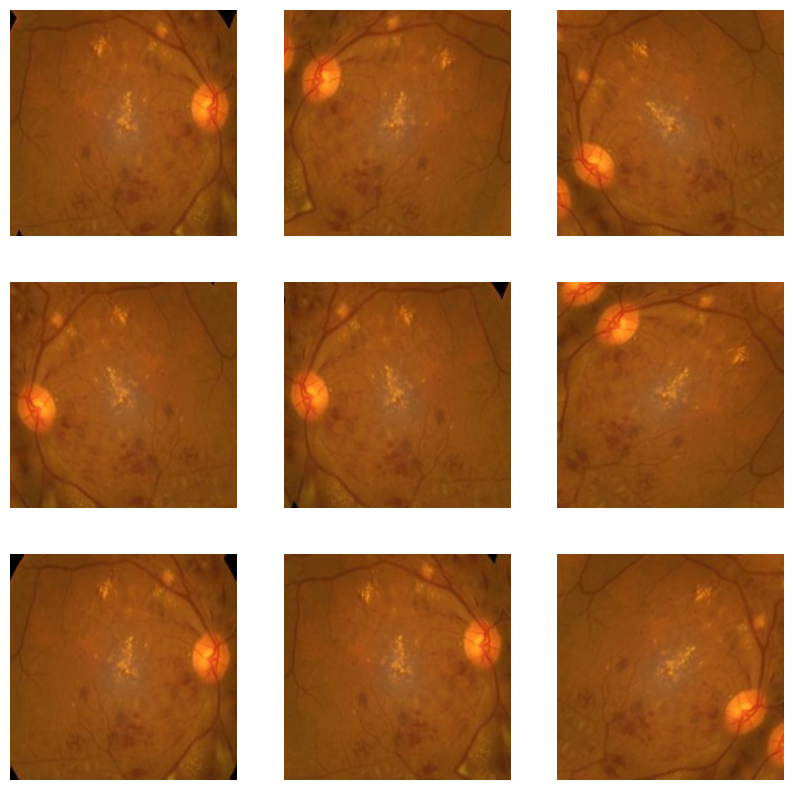

In [ ]:
augmenter = data_aug()

for image, _ in train_dataset.take(1):
  some_image = image[5]
  plt.figure(figsize=(10,10))

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augmenter(tf.expand_dims(some_image, 0))
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis('off')

### MobileNetV2

MobileNetV2 leverages depthwise separable convolutions to construct efficient building blocks. Traditional convolutions are resource-intensive, but depthwise separable convolutions mitigate this by reducing the number of trainable parameters and operations, and accelerating convolutions through a two-step process:

1. Depthwise Convolution: This initial step involves convolving each channel independently, generating an intermediate result.

2. Pointwise Convolution: The subsequent step merges the intermediate outputs from the depthwise convolution. This convolution produces a single result from each feature and applies it across all filters in the output layer, forming the final output. Essentially, it multiplies the shape of the depthwise convolution by the number of filters.



In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14536120/14536120 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
#testing the predictions of the base model

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [ ]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0], dtype=int32)>

In [ ]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

35363/35363 [==============================] - 0s 0us/step


[[('n04192698', 'shield', 0.09931519), ('n03249569', 'drum', 0.09226504)],
 [('n04192698', 'shield', 0.41387692),
  ('n04447861', 'toilet_seat', 0.07585211)],
 [('n03447721', 'gong', 0.21387342), ('n04192698', 'shield', 0.088339895)],
 [('n04192698', 'shield', 0.43855074), ('n04019541', 'puck', 0.13505891)],
 [('n07716906', 'spaghetti_squash', 0.29466578),
  ('n01968897', 'chambered_nautilus', 0.14099206)],
 [('n04019541', 'puck', 0.16675909), ('n04192698', 'shield', 0.16125555)],
 [('n04522168', 'vase', 0.3057811), ('n01910747', 'jellyfish', 0.09577072)],
 [('n03929660', 'pick', 0.19947454),
  ('n01496331', 'electric_ray', 0.070108674)],
 [('n03447721', 'gong', 0.14758024),
  ('n03590841', "jack-o'-lantern", 0.10152719)],
 [('n03447721', 'gong', 0.3556469), ('n04522168', 'vase', 0.13257523)],
 [('n03447721', 'gong', 0.66972345), ('n02939185', 'caldron', 0.104350254)],
 [('n04019541', 'puck', 0.12661871), ('n01910747', 'jellyfish', 0.051471915)],
 [('n04192698', 'shield', 0.15768573), 

There are many labels that the model outputs but none of them are even remotely close to what we want. Hence we customise it!

In [ ]:
def retinopathy_classifier(image_shape = IMG_SIZE, augmenter = data_aug()):

  input_shape = image_shape + (3,)

  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

  base_model.trainable = False        #freeze weights to make it non-trainable
  inputs = tf.keras.Input(shape=input_shape)

  x = augmenter(inputs)
  x = preprocess_input(x)                #use the same preprocessing as the original model to get good performance off the model
  x = base_model(x, training=False)      #set to False to avoid keeping track of statistics in the batch norm layer
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.2)(x)                    #add regularisation to avoid overfitting
  outputs = Dense(1,activation='linear')(x)
  model = tf.keras.Model(inputs, outputs)

  return model

In [ ]:
model1 = retinopathy_classifier(IMG_SIZE)
base_learning_rate = 0.001
model1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
epochs = 5
history = model1.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/5
65/65 [==============================] - 16s 145ms/step - loss: 0.4214 - accuracy: 0.7866 - val_loss: 0.3103 - val_accuracy: 0.8870
Epoch 2/5
65/65 [==============================] - 4s 58ms/step - loss: 0.2485 - accuracy: 0.8955 - val_loss: 0.2425 - val_accuracy: 0.9115
Epoch 3/5
65/65 [==============================] - 4s 63ms/step - loss: 0.2063 - accuracy: 0.9263 - val_loss: 0.2044 - val_accuracy: 0.9303
Epoch 4/5
65/65 [==============================] - 4s 57ms/step - loss: 0.1896 - accuracy: 0.9335 - val_loss: 0.1917 - val_accuracy: 0.9454
Epoch 5/5
65/65 [==============================] - 4s 57ms/step - loss: 0.1735 - accuracy: 0.9408 - val_loss: 0.1772 - val_accuracy: 0.9473


the base model achieved a validation accuracy of about 94% which is pretty good. It shows the effectiveness of transfer learning.

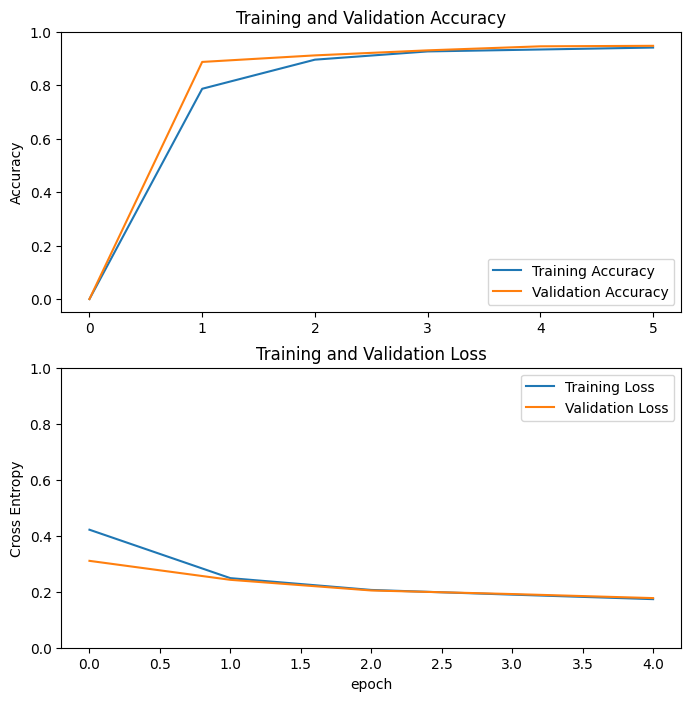

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
            descriptors.append(layer.strides)
            descriptors.append(layer.padding)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        if (type(layer) == ZeroPadding2D):
            descriptors.append(layer.padding)
        if (type(layer) == Dense):
            descriptors.append(layer.activation.__name__)
        result.append(descriptors)
    return result

In [ ]:
for layer in summary(model1):
    print(layer)

['InputLayer', [(None, 224, 224, 3)], 0]
['Sequential', (None, 224, 224, 3), 0]
['TFOpLambda', (None, 224, 224, 3), 0]
['TFOpLambda', (None, 224, 224, 3), 0]
['Functional', (None, 7, 7, 1280), 2257984]
['GlobalAveragePooling2D', (None, 1280), 0]
['Dropout', (None, 1280), 0, 0.2]
['Dense', (None, 1), 1281, 'linear']


### FINE TUNING

During transfer learning,

- freeze the earlier layers and train the later layers because they contain fine details(Ex: long hair, teeth) specific to your problem. Use a small learning learning rate during the training.

- use a very low learning rate so that we go in smaller steps and our model gets accustomed to more fine details leading to higher accuracy

In [ ]:
base_model = model1.layers[4]            #Functional layer
base_model.trainable = True
print(len(base_model.layers))

154


In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

fine_tune_from = [100+i*10 for i in range(6)]

layer_accuracy_tracker = {}

for i in fine_tune_from:
  for layer in base_model.layers[:i]:
    layer.trainable = False

  for layer in base_model.layers[i:]:
        layer.trainable = True

  loss_function=BinaryCrossentropy(from_logits=True)
  optimizer = Adam(learning_rate=0.1*base_learning_rate)
  metrics=['accuracy']

  model1.compile(loss=loss_function,
                 optimizer=optimizer,
                 metrics=metrics)

  fine_tune_epochs = 10
  history_finetuning = model1.fit(train_dataset,
                         epochs=fine_tune_epochs+epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

  validation_accuracy = history_finetuning.history['val_accuracy'][-1]
  layer_accuracy_tracker[i] = validation_accuracy

Epoch 5/15
65/65 [==============================] - 18s 101ms/step - loss: 0.3022 - accuracy: 0.8887 - val_loss: 0.1110 - val_accuracy: 0.9699
Epoch 6/15
65/65 [==============================] - 5s 76ms/step - loss: 0.1695 - accuracy: 0.9369 - val_loss: 0.1385 - val_accuracy: 0.9605
Epoch 7/15
65/65 [==============================] - 5s 79ms/step - loss: 0.1340 - accuracy: 0.9547 - val_loss: 0.1111 - val_accuracy: 0.9736
Epoch 8/15
65/65 [==============================] - 5s 78ms/step - loss: 0.1148 - accuracy: 0.9629 - val_loss: 0.1491 - val_accuracy: 0.9266
Epoch 9/15
65/65 [==============================] - 5s 76ms/step - loss: 0.1091 - accuracy: 0.9677 - val_loss: 0.0795 - val_accuracy: 0.9736
Epoch 10/15
65/65 [==============================] - 5s 83ms/step - loss: 0.0882 - accuracy: 0.9735 - val_loss: 0.2482 - val_accuracy: 0.9397
Epoch 11/15
65/65 [==============================] - 5s 76ms/step - loss: 0.0977 - accuracy: 0.9725 - val_loss: 0.0996 - val_accuracy: 0.9736
Epoch 12/

In [ ]:
print(layer_accuracy_tracker)

{100: 0.973634660243988, 110: 0.9623352289199829, 120: 0.9755178689956665, 130: 0.9755178689956665, 140: 0.973634660243988, 150: 0.9774011373519897}


In [ ]:
acc += history_finetuning.history['accuracy']
val_acc += history_finetuning.history['val_accuracy']

loss += history_finetuning.history['loss']
val_loss += history_finetuning.history['val_loss']

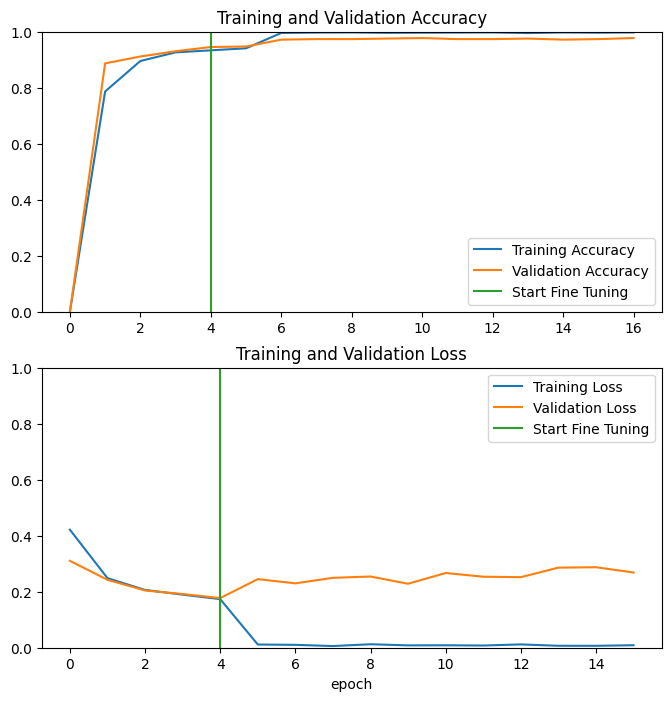

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
fine_tune_from_layer = max(layer_accuracy_tracker, key=layer_accuracy_tracker.get)

print(f"FineTuning from layer {fine_tune_from_layer} will give us the highest accuracy")

FineTuning from layer 150 will give us the highest accuracy


In [ ]:
for layer in base_model.layers[:fine_tune_from_layer]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_from_layer:]:
    layer.trainable = True

loss_function = BinaryCrossentropy(from_logits=True)
optimizer = Adam(learning_rate=0.1 * base_learning_rate)
metrics = ['accuracy']

model1.compile(loss=loss_function,
               optimizer=optimizer,
               metrics=metrics)

In [ ]:
test_loss, test_accuracy = model1.evaluate(test_dataset)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

8/8 [==============================] - 3s 203ms/step - loss: 0.4367 - accuracy: 0.9784
Test Accuracy: 0.9783549904823303
Test Loss: 0.4367307126522064


we get a generalisation accuracy of ≈ 98% when we train the MobileNetV2 from layer 150 boosting the accuracy by ≈ 3%